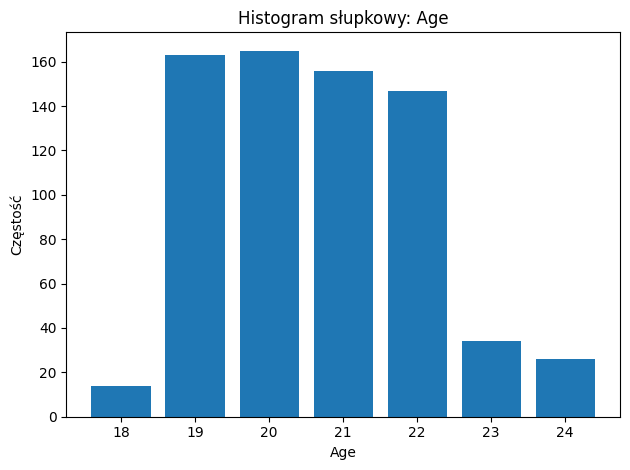

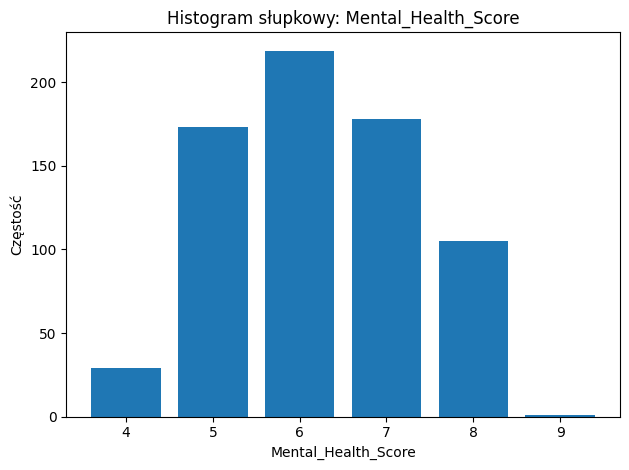

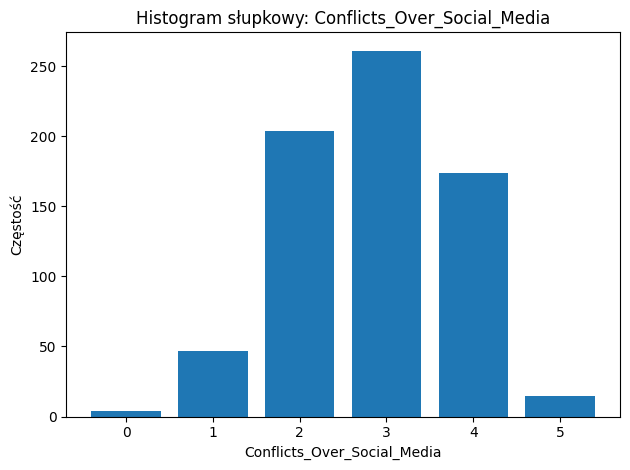

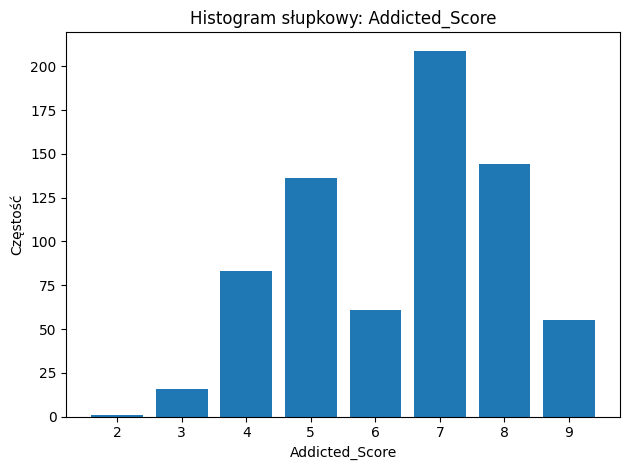

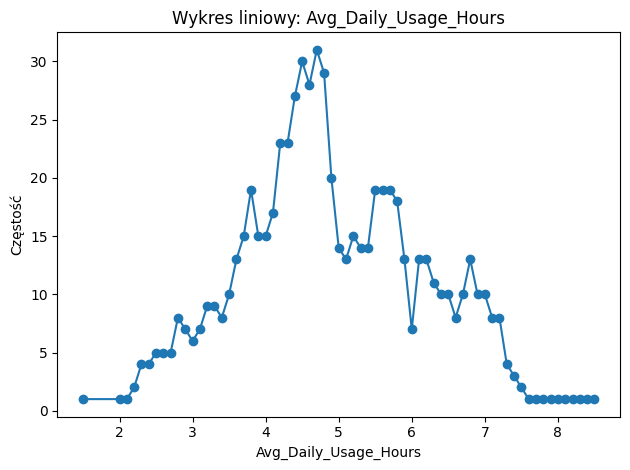

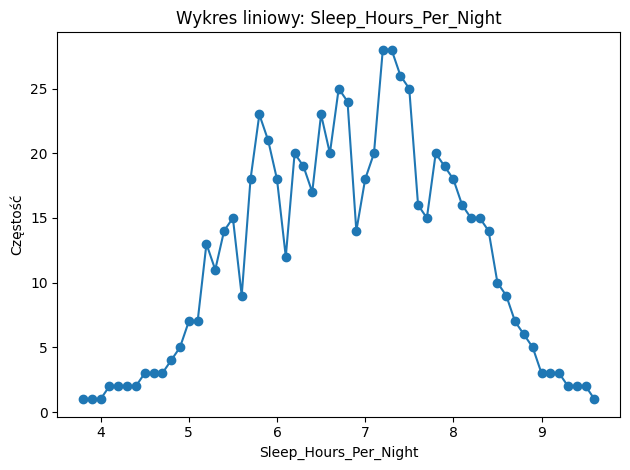

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("dataset/Students Social Media Addiction.csv")

# kolumny do histogramów słupkowych (liczbowe poza Avg_Daily_Usage_Hours i Sleep_Hours_Per_Night)
bar_cols = [
    col for col in df.select_dtypes(include="number").columns
    if col not in ["Student_ID", "Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]
]

# rysowanie histogramów słupkowych
for col in bar_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel(col)
    plt.ylabel("Częstość")
    plt.title(f"Histogram słupkowy: {col}")
    plt.tight_layout()
    plt.show()

# kolumny do wykresów liniowych
line_cols = ["Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]

# rysowanie wykresów liniowych
for col in line_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure()
    plt.plot(counts.index, counts.values)
    plt.scatter(counts.index, counts.values)  # punkty dla czytelności
    plt.xlabel(col)
    plt.ylabel("Częstość")
    plt.title(f"Wykres liniowy: {col}")
    plt.tight_layout()
    plt.show()


## Przygotowanie Danych

- usuwanie kolumny Student_id
- zmiana wartości kategorycznych na numeryczne
- stworzenie nowej kolumny z coutry na Region z powodu małej liczby powtórzeń krajów
- usuwanie przypadków odstających w godzinach używania social media i godzinach snu (jeśli takie istnieją)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import country_converter as coco
from IPython.display import display, Markdown

# 1. Wczytanie danych
df = pd.read_csv("dataset/Students Social Media Addiction.csv")

# 2. Zamiana Country → Region
if "Country" in df.columns:
    override = {"UAE": "United Arab Emirates"}
    df["Country"] = df["Country"].replace(override)
    df["Region"] = coco.convert(names=df["Country"], to="continent")

# 3. Usuwamy zbędne
for col in ["Country", "Student_ID"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# 4. Label Encoding
label_cols = [
    "Gender",
    "Affects_Academic_Performance",
    "Academic_Level",
    "Relationship_Status"
]
label_maps = {}
for col in label_cols:
    le = LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])
    # zapisz mapowanie
    label_maps[col] = pd.DataFrame({
        "Category": le.classes_,
        "Code": range(len(le.classes_))
    })
    # pokaż w Jupyterze
    display(Markdown(f"### Label mapping dla `{col}`"))
    display(label_maps[col])


# 5. One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# dopasuj na dwóch kolumnach naraz
X_ohe = ohe.fit_transform(df[["Most_Used_Platform", "Region"]])
new_cols = ohe.get_feature_names_out(["Most_Used_Platform", "Region"])
df_ohe = pd.DataFrame(X_ohe, columns=new_cols, index=df.index)

# budujemy mapowania per oryginalna kolumna
onehot_maps = {}
cats = ohe.categories_  # lista list: [platforms…, regions…]
for orig_col, cat_list in zip(["Most_Used_Platform", "Region"], cats):
    # wybierz feature names odpowiadające tej kolumnie
    prefix = orig_col + "_"
    feats = [c for c in new_cols if c.startswith(prefix)]
    onehot_maps[orig_col] = pd.DataFrame({
        "Category": cat_list,
        "OneHotColumn": feats
    })
    # wyświetl
    display(Markdown(f"### One-hot mapping dla `{orig_col}`"))
    display(onehot_maps[orig_col])

# 6. Ściągamy stare kolumny i dodajemy nowe wektory
df = pd.concat([df.drop(columns=["Most_Used_Platform", "Region"]), df_ohe], axis=1)

# 7. Analiza outlierów (IQR) – bez zmian
cols = ["Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]
iqr_bounds = {}
for col in cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    iqr_bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

mask = pd.Series(True, index=df.index)
for col, (low, high) in iqr_bounds.items():
    mask &= df[col].between(low, high)

outliers_iqr = df[~mask]
print("Outliery wg IQR dla Avg_Daily_Usage_Hours i Sleep_Hours_Per_Night:" + '\n')
print(outliers_iqr[cols])

### Label mapping dla `Gender`

,Category,Code
0,Female,0
1,Male,1


### Label mapping dla `Affects_Academic_Performance`

,Category,Code
0,No,0
1,Yes,1


### Label mapping dla `Academic_Level`

,Category,Code
0,Graduate,0
1,High School,1
2,Undergraduate,2


### Label mapping dla `Relationship_Status`

,Category,Code
0,Complicated,0
1,In Relationship,1
2,Single,2


### One-hot mapping dla `Most_Used_Platform`

,Category,OneHotColumn
0,Facebook,Most_Used_Platform_Facebook
1,Instagram,Most_Used_Platform_Instagram
2,KakaoTalk,Most_Used_Platform_KakaoTalk
3,LINE,Most_Used_Platform_LINE
4,LinkedIn,Most_Used_Platform_LinkedIn
5,Snapchat,Most_Used_Platform_Snapchat
6,TikTok,Most_Used_Platform_TikTok
7,Twitter,Most_Used_Platform_Twitter
8,VKontakte,Most_Used_Platform_VKontakte
9,WeChat,Most_Used_Platform_WeChat


### One-hot mapping dla `Region`

,Category,OneHotColumn
0,Africa,Region_Africa
1,America,Region_America
2,Asia,Region_Asia
3,Europe,Region_Europe
4,Oceania,Region_Oceania


Outliery wg IQR dla Avg_Daily_Usage_Hours i Sleep_Hours_Per_Night:

     Avg_Daily_Usage_Hours  Sleep_Hours_Per_Night
6                      1.5                    8.0
486                    8.4                    3.9
496                    8.5                    3.8


,Age,Gender,Academic_Level,Avg_Daily_Usage_Hours,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score,...,Most_Used_Platform_Twitter,Most_Used_Platform_VKontakte,Most_Used_Platform_WeChat,Most_Used_Platform_WhatsApp,Most_Used_Platform_YouTube,Region_Africa,Region_America,Region_Asia,Region_Europe,Region_Oceania
0,19,0,2,5.2,1,6.5,6,1,3,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,1,0,2.1,0,7.5,8,2,0,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,20,0,2,6.0,1,5.0,5,0,4,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,18,1,1,3.0,0,7.0,7,2,1,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,21,1,0,4.5,1,6.0,6,1,2,7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Korelacja Zmiennych part 1



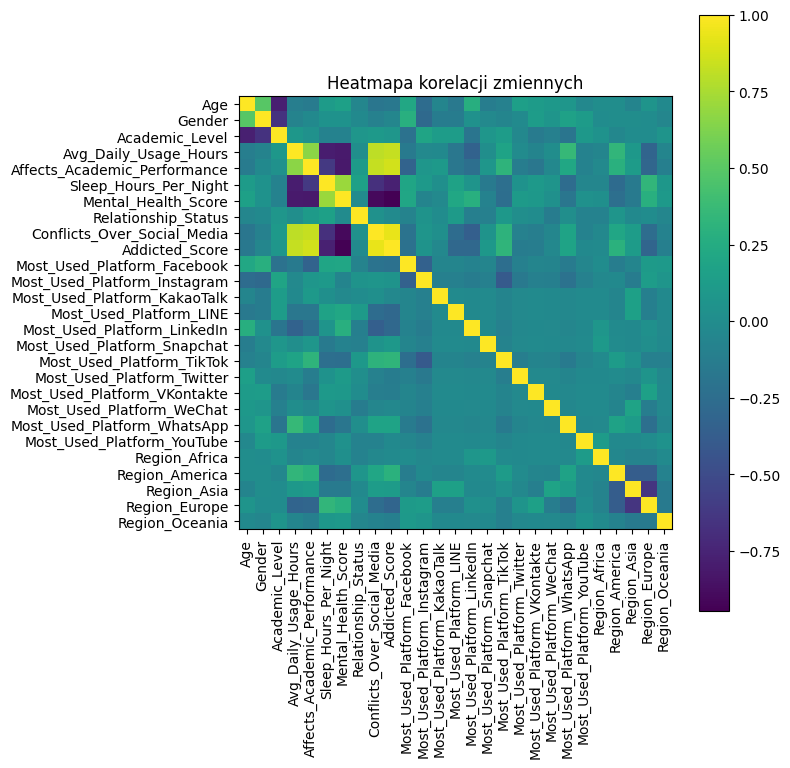

In [9]:
import matplotlib.pyplot as plt

# 2. Oblicz macierz korelacji
corr = df.corr()

# Heatmapa
plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal')
plt.colorbar()
# opisy osi
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Heatmapa korelacji zmiennych")
plt.tight_layout()
plt.show()

## Korelacja zmiennych part 2



In [113]:
import scipy.stats as st

# t-test między płciami
m = df[df.Gender==0].Addicted_Score
f = df[df.Gender==1].Addicted_Score
print("t-test p-value:", st.ttest_ind(m, f, nan_policy="omit").pvalue)


t-test p-value: 0.18754394786021147
